# Books Recommendation Engine

* This notebook recommends a set of books similar to other books based on crowdsourced book rating by users
* It uses item based collberative filtering to achieve this

In [1]:
#libraries

%matplotlib inline
import pandas as pd
import numpy as np
from numpy import int64

import requests
import IPython.display as Disp

import sklearn
from sklearn.decomposition import TruncatedSVD


### Read dataset 

In [2]:
books_df = pd.read_csv("./dataset/books.csv")
ratings_df = pd.read_csv("./dataset/ratings.csv", encoding='UTF-8',  dtype={'user_id': int,'book_id':int, 'rating':int} )

In [3]:
books_df.head()
#ratings_df.head()

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,...,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,...,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,...,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...


In [4]:
books_df.describe()

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn13,original_publication_year,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5
count,10000.00000,1.000000e+04,1.000000e+04,1.000000e+04,10000.000000,9.415000e+03,9979.000000,10000.000000,1.000000e+04,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,1.000000e+04
mean,5000.50000,5.264697e+06,5.471214e+06,8.646183e+06,75.712700,9.755044e+12,1981.987674,4.002191,5.400124e+04,5.968732e+04,2919.955300,1345.040600,3110.885000,11475.893800,1.996570e+04,2.378981e+04
std,2886.89568,7.575462e+06,7.827330e+06,1.175106e+07,170.470728,4.428619e+11,152.576665,0.254427,1.573700e+05,1.678038e+05,6124.378132,6635.626263,9717.123578,28546.449183,5.144736e+04,7.976889e+04
min,1.00000,1.000000e+00,1.000000e+00,8.700000e+01,1.000000,1.951703e+08,-1750.000000,2.470000,2.716000e+03,5.510000e+03,3.000000,11.000000,30.000000,323.000000,7.500000e+02,7.540000e+02
25%,2500.75000,4.627575e+04,4.791175e+04,1.008841e+06,23.000000,9.780316e+12,1990.000000,3.850000,1.356875e+04,1.543875e+04,694.000000,196.000000,656.000000,3112.000000,5.405750e+03,5.334000e+03
50%,5000.50000,3.949655e+05,4.251235e+05,2.719524e+06,40.000000,9.780452e+12,2004.000000,4.020000,2.115550e+04,2.383250e+04,1402.000000,391.000000,1163.000000,4894.000000,8.269500e+03,8.836000e+03
75%,7500.25000,9.382225e+06,9.636112e+06,1.451775e+07,67.000000,9.780831e+12,2011.000000,4.180000,4.105350e+04,4.591500e+04,2744.250000,885.000000,2353.250000,9287.000000,1.602350e+04,1.730450e+04
max,10000.00000,3.328864e+07,3.553423e+07,5.639960e+07,3455.000000,9.790008e+12,2017.000000,4.820000,4.780653e+06,4.942365e+06,155254.000000,456191.000000,436802.000000,793319.000000,1.481305e+06,3.011543e+06


In [5]:
books_df_2 = books_df[['book_id', 'books_count', 'original_publication_year', 'average_rating','original_title','image_url','authors']]

books_df_2.head()

#len(books_df)

,book_id,books_count,original_publication_year,average_rating,original_title,image_url,authors
0,1,272,2008.0,4.34,The Hunger Games,https://images.gr-assets.com/books/1447303603m...,Suzanne Collins
1,2,491,1997.0,4.44,Harry Potter and the Philosopher's Stone,https://images.gr-assets.com/books/1474154022m...,"J.K. Rowling, Mary GrandPré"
2,3,226,2005.0,3.57,Twilight,https://images.gr-assets.com/books/1361039443m...,Stephenie Meyer
3,4,487,1960.0,4.25,To Kill a Mockingbird,https://images.gr-assets.com/books/1361975680m...,Harper Lee
4,5,1356,1925.0,3.89,The Great Gatsby,https://images.gr-assets.com/books/1490528560m...,F. Scott Fitzgerald


<AxesSubplot:>

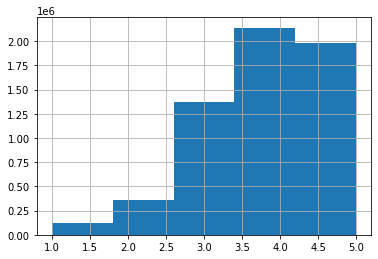

In [6]:
ratings_df.rating.hist(bins=5)

In [26]:
ratings_df.head()

,user_id,book_id,rating
0,1,258,5
1,2,4081,4
2,2,260,5
3,2,9296,5
4,2,2318,3


In [7]:
ratings_df.describe()

,user_id,book_id,rating
count,5.976479e+06,5.976479e+06,5.976479e+06
mean,2.622446e+04,2.006477e+03,3.919866e+00
std,1.541323e+04,2.468499e+03,9.910868e-01
min,1.000000e+00,1.000000e+00,1.000000e+00
25%,1.281300e+04,1.980000e+02,3.000000e+00
50%,2.593800e+04,8.850000e+02,4.000000e+00
75%,3.950900e+04,2.973000e+03,5.000000e+00
max,5.342400e+04,1.000000e+04,5.000000e+00


In [8]:
ratings_df.groupby('user_id')['rating'].count()

user_id
1        117
2         65
3         91
4        134
5        100
        ... 
53420    110
53421    110
53422    130
53423     77
53424    133
Name: rating, Length: 53424, dtype: int64

## Merge books and ratings dataset

In [9]:
combined_books_df = pd.merge(ratings_df, books_df_2, on='book_id')

In [10]:
combined_books_df.head()

,user_id,book_id,rating,books_count,original_publication_year,average_rating,original_title,image_url,authors
0,1,258,5,279,2001.0,4.24,La sombra del viento,https://images.gr-assets.com/books/1344545047m...,"Carlos Ruiz Zafón, Lucia Graves"
1,11,258,3,279,2001.0,4.24,La sombra del viento,https://images.gr-assets.com/books/1344545047m...,"Carlos Ruiz Zafón, Lucia Graves"
2,143,258,4,279,2001.0,4.24,La sombra del viento,https://images.gr-assets.com/books/1344545047m...,"Carlos Ruiz Zafón, Lucia Graves"
3,242,258,5,279,2001.0,4.24,La sombra del viento,https://images.gr-assets.com/books/1344545047m...,"Carlos Ruiz Zafón, Lucia Graves"
4,325,258,4,279,2001.0,4.24,La sombra del viento,https://images.gr-assets.com/books/1344545047m...,"Carlos Ruiz Zafón, Lucia Graves"


### Get most rated books

In [11]:
combined_books_df.groupby('book_id')['rating'].count().sort_values(ascending=False)

book_id
1       22806
2       21850
4       19088
3       16931
5       16604
        ...  
9315       36
1935       33
9486       24
9345       11
7803        8
Name: rating, Length: 10000, dtype: int64

In [28]:
top10 = combined_books_df['book_id'] < 11
combined_books_df[top10]['original_title'].unique()
#printBookCover(Filter)

array(["Harry Potter and the Philosopher's Stone", 'The Great Gatsby',
       'The Catcher in the Rye', 'Angels & Demons ',
       'Pride and Prejudice', 'To Kill a Mockingbird',
       'The Hobbit or There and Back Again', 'Twilight',
       'The Hunger Games', 'The Fault in Our Stars'], dtype=object)

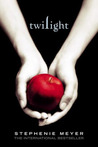

In [29]:
url =combined_books_df[top10]['image_url'].unique()[7]
Disp.Image(requests.get(url).content)

### Create Pivot Table of User Vs Movies

In [14]:
ct_df = combined_books_df.pivot_table(values='rating', index='user_id', columns='original_title', fill_value=0)

In [15]:
ct_df.head()

original_title,,A Monster Calls,Animal Farm & 1984,"Burned (Burned, #1)",Call the midwife : a true story of the East End in the 1950s,"Carry On, Warrior: Thoughts on Life Unarmed",Carter Beats the Devil,Crown of Shadows,Daemon,De Imitatione Christi,...,電撃デイジー 1,青の祓魔師 1,青の祓魔師 2,高校デビュー 1,黑暗森林,黒執事 I [Kuroshitsuji I],黒執事 II [Kuroshitsuji II],黒執事 III [Kuroshitsuji III],엄마를 부탁해,채식주의자
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
X = ct_df.values.T
X.shape


(9274, 53424)

### Compress dataset by applying Singular Value Decomposistion (SVD)

In [17]:
SVD  = TruncatedSVD(n_components=20, random_state=17)
result_matrix = SVD.fit_transform(X)
result_matrix.shape

(9274, 20)

### Create Pearson coorelation matrix

In [31]:
corr_mat = np.corrcoef(result_matrix)
corr_mat.shape

(9274, 9274)

### Print books related to specified book


In [19]:
book_names = ct_df.columns
book_list = list(book_names)
print(book_list)

[' ', ' A Monster Calls ', ' Animal Farm & 1984', ' Burned (Burned, #1)', ' Call the midwife : a true story of the East End in the 1950s', ' Carry On, Warrior: Thoughts on Life Unarmed ', ' Carter Beats the Devil', ' Crown of Shadows', ' Daemon', ' De Imitatione Christi', ' Evil at Heart', ' Faust. Der Tragödie erster und zweiter Teil ', ' Feeling Good: The New Mood Therapy', ' Innocent Traitor', ' Kaleidoscope Hearts', ' NW ', ' The Fellowship of the Ring', ' The Sea of Trolls', ' The Tale of Despereaux', ' Игрок ', ' الرحيق المختوم: بحث في السيرة النبوية على صاحبها أفضل الصلاة والسلام ', ' رأيت رام الله', ' سمفونی مردگان', ' めくらやなぎと、眠る女 [Mekurayanagi to, nemuru onna]', ' ソウルイーター 2', ' 国境の南、太陽の西 [Kokkyō no minami, taiyō no nishi]', ' 絶対彼氏 (Zettai Kareshi) 1', '"...And Ladies of the Club"', '"D" is for Deadbeat ', '"M" is for Malice', '"N" is for Noose', '"O" is for Outlaw', '"P" is for Peril', '"Q" is for Quarry', '"Who Could That Be at This Hour?"', '"حكايات فرغلي المستكاوي "حكايتى م

In [32]:
hunger_game_index = book_list.index('Twilight')
hunger_game_index

8491

In [33]:
corr_hunger_games = corr_mat[hunger_game_index]
#corr_hunger_games.shape
print(corr_hunger_games)

[ 0.28056891  0.23951661  0.25658596 ...  0.49666038  0.11244917
 -0.02906022]


In [34]:
list(book_names[(corr_hunger_games<1.0) & (corr_hunger_games>0.8)])

['A Walk to Remember',
 'Act Like a Lady, Think Like a Man',
 'Boy Meets Girl',
 'Breaking Dawn',
 'Can You Keep a Secret?',
 'Confessions of a Shopaholic',
 'Eclipse',
 'Eclipse: The Official Illustrated Movie Companion',
 "Every Boy's Got One (Boy, #3)",
 'Fools Rush In (Weddings by Bella, #1)',
 'Insatiable',
 'Midnight Sun (Partial Draft)',
 'New Moon (Twilight, #2)',
 'New Moon: The Complete Illustrated Movie Companion',
 'PS, I Love You',
 'Queen of Babble',
 'Queen of Babble Gets Hitched',
 'Queen of Babble in the Big City',
 'Reunion',
 'Size 12 Is Not Fat (Heather Wells, #1)',
 'Size 14 Is Not Fat Either',
 'The Boy Next Door (Boy #1)',
 'The Gift',
 'The Host',
 'The Hunger Games',
 'The Notebook',
 'The Short Second Life of Bree Tanner',
 'The Twilight Collection (Twilight, #1-3)',
 'The Twilight Saga',
 'The Twilight Saga: The Official Guide',
 'The girl who was on fire',
 "Twilight Director's Notebook",
 'Twilight: The Complete Illustrated Movie Companion',
 'Vision in Whi

# Building the function that will be used in the flask app

In [23]:
def getRecommendations(bookName):
    book_name_index = book_list.index(bookName)
    corr_book = corr_mat[book_name_index]
    recList = list(book_names[(corr_book<1.0) & (corr_book>0.9)])
    max=5
    if(len(recList)<5):
        max=len(recList)
    return books_df_2[books_df_2.original_title.isin(recList)]

In [36]:
getRecommendations("The Great Gatsby")

,book_id,books_count,original_publication_year,average_rating,original_title,image_url,authors
3,4,487,1960.0,4.25,To Kill a Mockingbird,https://images.gr-assets.com/books/1361975680m...,Harper Lee
7,8,360,1951.0,3.79,The Catcher in the Rye,https://images.gr-assets.com/books/1398034300m...,J.D. Salinger
12,13,995,1949.0,4.14,Nineteen Eighty-Four,https://images.gr-assets.com/books/1348990566m...,"George Orwell, Erich Fromm, Celâl Üster"
13,14,896,1945.0,3.87,Animal Farm: A Fairy Story,https://images.gr-assets.com/books/1424037542m...,George Orwell
27,28,458,1954.0,3.64,Lord of the Flies,https://images.gr-assets.com/books/1327869409m...,William Golding
28,29,1937,1595.0,3.73,An Excellent conceited Tragedie of Romeo and J...,https://images.gr-assets.com/books/1327872146m...,"William Shakespeare, Robert Jackson"
31,32,373,1937.0,3.84,Of Mice and Men,https://images.gr-assets.com/books/1437235233m...,John Steinbeck
57,58,2277,1884.0,3.80,The Adventures of Huckleberry Finn,https://images.gr-assets.com/books/1405973850m...,"Mark Twain, John Seelye, Guy Cardwell"
128,129,275,1962.0,4.18,One Flew Over the Cuckoo's Nest,https://images.gr-assets.com/books/1485308778m...,Ken Kesey
455,456,109,1947.0,3.97,A Streetcar Named Desire,https://s.gr-assets.com/assets/nophoto/book/11...,Tennessee Williams
